In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/face recognition/face recognition

/content/drive/My Drive/face recognition/face recognition


#**RECOGNIZE FACES**

####**IMPORT LIBRARIES AND LOAD NETWORK**

In [ ]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import PIL.ImageOps  

import torch
from torch.autograd import Variable  
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils

from torch.utils.data import DataLoader, Dataset

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 128)) # 5 features, 128 features

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # flattening .. connect to fully connected layer
        output = self.fc1(output)
        return output

    def forward(self, inp): # invoked automatically when you pass an image to object
        rep = self.forward_once(inp)
        return rep

In [ ]:
net = SiameseNetwork()
net.load_state_dict(torch.load('./models/siam_net_new_task2.pth'))
net.eval()
net.cuda()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=128, bias=True)
  )
)

In [ ]:
training_dir = "./data/data_new/dataset_task2/training/"
testing_dir = "./data/data_new/dataset_task2/unknown"

In [ ]:
def get_class_test(l1,folder):
  """
  This function returns the label of the images selected
  """
  for key,val in folder.class_to_idx.items():
    if val == l1:
      c1 = key
      break
  return c1

####**LOAD TEST DATA**

It contains 3 distinct images of people

In [ ]:
f_data_img = dset.ImageFolder(root=testing_dir,
                              transform=transforms.Compose([transforms.Resize((100,100)),
                                                              transforms.Grayscale(num_output_channels=1),
                                                              transforms.ToTensor()
                                                                      ]))
dataloader_test = DataLoader(f_data_img,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(dataloader_test)

# RuntimeError: Given groups=1, weight of size [4, 1, 3, 3], expected 
# input[1, 3, 102, 102] to have 1 channels, but got 3 channels instead
# When image is loaded by default it is considered as rgb, we need to convert to grayscale
# pytorch uses PIL to load image and converts it to RGB


In [ ]:
len(dataloader_test)

4

In [ ]:
input = []
output = []

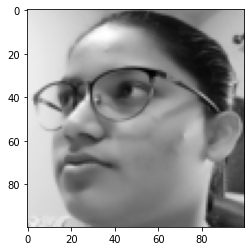

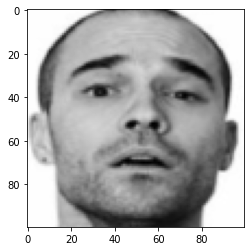

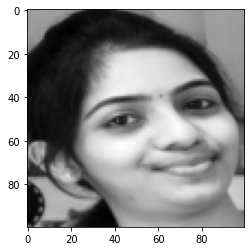

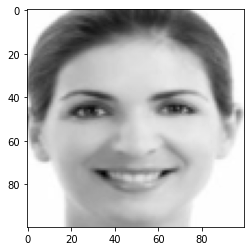

In [ ]:
for i in range(4):
  sample = next(dataiter)
  img0 = sample[0]
  img0 = img0.cuda()
  out0 = net(Variable(img0))

  input.append(img0)
  output.append(out0)

  plt.imshow(img0[0][0].data.cpu().numpy(),cmap='gray')
  plt.show()

In [ ]:
# get the train data
f_data = dset.ImageFolder(root=training_dir,
                          transform=transforms.Compose([transforms.Resize((100,100)),
                                                              transforms.Grayscale(num_output_channels=1),
                                                              transforms.ToTensor()
                                                                      ]))

dataloader_train = DataLoader(f_data,num_workers=6,batch_size=1,shuffle=True)



In [ ]:
def calculate_scores(loader,out0):
  scores = {} # to store euclidean distance,{'classname':distance}
  #imgs = {} # to get the images corresponding to the distance,{distance : image representation}
  rev_scores = {} 

  for i in range(len(loader)):
    sample = next(iter(loader))
    img = sample[0]
    img = img.cuda()
    out = net(Variable(img))
    c1 = get_class_test(sample[1],f_data)
    
    euclidean_distance = F.pairwise_distance(out0, out)

    scores[str(c1)+" "+str(i)] = euclidean_distance.data.cpu().numpy()[0]
    rev_scores[euclidean_distance.data.cpu().numpy()[0]] = str(c1)
    #imgs[euclidean_distance.data.cpu().numpy()[0]] = img

  return scores, rev_scores
    

In [ ]:
def knn(inp,out0,loader_train,k=3):

  scores, rev_scores = calculate_scores(loader_train,out0)
  #print(scores)
  # sorting the distance
  score_values = list(scores.values())
  score_values.sort()
  #print(score_values)
  # get the k nearest neighbors
  near_neighbors = []
  for i in range(k):
    near_neighbors.append(score_values[i])
  #print(near_neighbors)    

  # get classes of nearest neighbors
  clas = []
  score = {}
  for i in range(k):
    clas.append(rev_scores[near_neighbors[i]])
    score[rev_scores[near_neighbors[i]]] = near_neighbors[i]
  #print(clas)

  #get the majority vote class
  max = clas.count(clas[0])
  c = clas[0]
  for i in range(1,k):
    if clas.count(clas[i])>max:
      max = clas.count(clas[i])
      c = clas[i]
  #print(max," ",c)

  # get the image corresponding to the class
  return c

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-88agefu5'


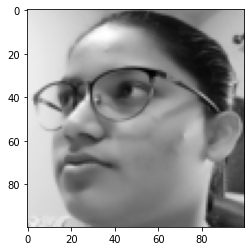

Name: aish


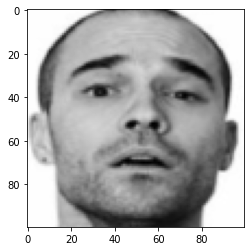

Name: vijj


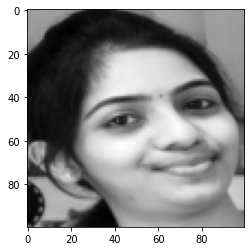

Name: Anuhya


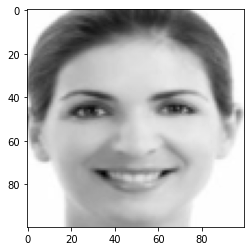

Name: samreen


In [ ]:
for i in range(4):
  c = knn(input[i],output[i],dataloader_train)
  plt.imshow(input[i][0][0].data.cpu().numpy(),cmap='gray')
  plt.show()
  print('Name: '+c)